# Visualization Catalog

- [Map Crime Data to Geographic Data](#1)
- [Map of City-Level Crime Numbers](#2)
- [Word Cloud](#3)
    - [NumberOnMap](NumberOnMap.html)
- [Place Word Clouds on The Map](#4)
    - [WordCloudOnMap](WordCloudOnMap.html)

<a id=1></a>
## Map Crime Data to Geographic Data

In [1]:
import geopandas as gpd
import pandas as pd
import re

In [58]:
# Load the shape file of the map of China
china_map = gpd.read_file('viz_materials/map/city.shp')

# Select the subset of the geographic data
china_map = china_map.iloc[:, [0, 4]]
china_map.columns = ["City_CN", "geometry"]

china_map.head()

,City_CN,geometry
0,阿坝藏族羌族自治州,"POLYGON ((102.95840 34.27996, 102.95933 34.270..."
1,阿克苏地区,"POLYGON ((82.82279 42.64573, 82.82544 42.64289..."
2,阿拉尔市,"POLYGON ((81.86460 40.94205, 81.86914 40.94097..."
3,阿拉善盟,"POLYGON ((99.00000 42.60309, 99.50532 42.56749..."
4,阿勒泰地区,"POLYGON ((87.79720 49.18060, 87.81916 49.17268..."


In [59]:
# Load the crime data
crime = pd.read_csv("data.csv", encoding="utf-8")

# Split the location into City and Province columns
crime.columns = ["Count", "City_CN", "Location"]
crime.loc[:, "City"] = crime.Location.apply(lambda x: re.findall(r"\w+", x)[0])
crime.loc[:, "Province"] = crime.Location.apply(lambda x: re.findall(r"\w+", x)[1])

In [60]:
# Check unusual splitting results of provinces
crime[crime.Province.apply(lambda x: len(x) < 5)]

,Count,City_CN,Location,City,Province
26,1,延安市,"(""Yan'an"", 'Shaanxi')",Yan,an
40,1,普洱市,"(""Pu'er"", 'Yunnan')",Pu,er
145,4,广安市,"(""Guang'an"", 'Sichuan')",Guang,an
223,9,六安市,"(""Lu'an"", 'Anhui')",Lu,an
232,10,淮安市,"(""Huai'an"", 'Jiangsu')",Huai,an
259,30,西安市,"(""Xi'an"", 'Shaanxi')",Xi,an


In [61]:
# Check unusual splitting results of cities
crime[crime.City.apply(lambda x: len(x) < 5)]

,Count,City_CN,Location,City,Province
26,1,延安市,"(""Yan'an"", 'Shaanxi')",Yan,an
40,1,普洱市,"(""Pu'er"", 'Yunnan')",Pu,er
107,2,阿坝藏族羌族自治州,"('Aba', 'Sichuan')",Aba,Sichuan
123,3,淄博市,"('Zibo', 'Shandong')",Zibo,Shandong
126,3,菏泽市,"('Heze', 'Shandong')",Heze,Shandong
136,3,马鞍山市,"(""Ma'anshan"", 'Anhui')",Ma,anshan
173,5,大理白族自治州,"('Dali', 'Yunnan')",Dali,Yunnan
177,5,无锡市,"('Wuxi', 'Jiangsu')",Wuxi,Jiangsu
223,9,六安市,"(""Lu'an"", 'Anhui')",Lu,an
232,10,淮安市,"(""Huai'an"", 'Jiangsu')",Huai,an


In [62]:
# Manually repair inaccurate splits
wrong_index = [26, 40, 136, 145, 223, 232, 259]
correct_location = [["Yan'an", "Shaanxi"],
                    ["Pu'er", "Yunnan"],
                    ["Ma'anshan", "Anhui"],
                    ["Guang'an", "Sichuan"],
                    ["Lu'an", "Anhui"],
                    ["Huai'an", "Jiangsu"],
                    ["Xi'an", "Shaanxi"]]

for n, i in enumerate(wrong_index):
    crime.loc[i, ["City", "Province"]] = correct_location[n]

In [63]:
# Drop the redundant column
crime.drop("Location", axis=1, inplace=True)
crime.head()

,Count,City_CN,City,Province
0,1,七台河市,Qitaihe,Heilongjiang
1,1,三明市,Sanming,Fujian
2,1,三门峡市,Sanmenxia,Henan
3,1,东营市,Dongying,Shandong
4,1,临汾市,Linfen,Shanxi


In [23]:
# Merge the crime data with the geographic data using Chinese names of the cities
merged_df = pd.merge(china_map, crime, on="City_CN", how = "right")
merged_df.head()

,City_CN,geometry,Count,City,Province
0,七台河市,"POLYGON ((131.27322 46.32068, 131.27301 46.320...",1,Qitaihe,Heilongjiang
1,三明市,"POLYGON ((117.30633 27.11907, 117.31564 27.117...",1,Sanming,Fujian
2,三门峡市,"POLYGON ((111.96644 35.07208, 111.96662 35.071...",1,Sanmenxia,Henan
3,东营市,"MULTIPOLYGON (((119.22069 37.78119, 119.22052 ...",1,Dongying,Shandong
4,临汾市,"POLYGON ((110.71945 36.91298, 110.73457 36.907...",1,Linfen,Shanxi


In [12]:
# Render geojson file
(merged_df.drop("City_CN", axis=1)
          .to_file("viz_materials/city_crime.geojson",
                   driver="GeoJSON",
                   encoding="utf-8"))

<a id=2></a>
## Map of City-Level Crime Numbers

Interact with [NumberOnMap](NumberOnMap.html) and more learn about the data.

In [32]:
from bokeh.io import show, output_file
from bokeh.models import GeoJSONDataSource, LinearColorMapper, HoverTool
from bokeh.palettes import Reds6 as palette
from bokeh.plotting import figure

In [33]:
# load geojson file rendered in the last part
with open("viz_materials/city_crime.geojson") as f:
    geo_source = GeoJSONDataSource(geojson=f.read())

# Set the appearance of the map
palette = tuple(reversed(palette))
color_mapper = LinearColorMapper(palette=palette)
TOOLS = "pan,wheel_zoom,reset,hover,save"

# Plot the map with the crime data
p = figure(title="Crime Case Counts",
           tools=TOOLS,
           x_axis_location=None, y_axis_location=None,
           width=600, height=600)

p.grid.grid_line_color = None

p.patches("xs", "ys",
          fill_alpha=0.7,
          fill_color={'field': 'Count',
                      'transform': color_mapper}, 
          line_color='white', line_width=0.5,
          source=geo_source)

# Set the hover of the map
hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("City", "@City"),
    ("Count", "@Count"),
    ("(Lng, Lat)", "($x, $y)")
]

# Save the map to repository
output_file("NumberOnMap.html", title="Crime Case Counts")

<a id=3></a>
## Word Cloud

In [34]:
%matplotlib inline
import jieba
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import warnings

In [35]:
warnings.filterwarnings("ignore")

# Load customized dictionary
jieba.load_userdict("viz_materials/word_dictionary.txt")

In [36]:
# Load case data matched with cities
cases = pd.read_csv("matches.csv")

# Group by city and concatenate the cases
gb = cases.groupby("location").sum()

# Extract the top 10 cities with the most cases
crime_top10 = crime.sort_values("Count", ascending=False).head(10)
gb_top10 = pd.merge(
    gb, crime_top10,
    left_on=gb.index,
    right_on="City_CN",
    how="right"
)
gb_top10

,case,Count,City_CN,City,Province
0,北京工业大学2001级工商管理系男学生郭某某杀害女友被判无期后减刑9次，出狱后拒戴口罩打死老...,88,北京市,Beijing,Beijing
1,江苏南京大学暑期支教女学生洗澡被偷拍，做案者仅罚款500元原北大教师沈阳被指“性侵女生致其自...,48,南京市,Nanjing,Jiangsu
2,安徽巢湖烔炀镇白庙唐村一男子唐某根将妻子勒死家中，逃亡36年安徽合肥银马公寓一男子杀妻后跳楼...,44,合肥市,Hefei,Anhui
3,上海东华大学04级研究生章胜偷窥女生如厕上海财经大学副教授钱逢胜被曝性侵女学生上海海事大学解...,42,上海市,Shanghai,Shanghai
4,网曝华南理工大学公共管理学院副教授王雨磊性侵女学生网曝华南理工大学公共管理学院院长王郅强性侵...,40,广州市,Guangzhou,Guangdong
5,四川美术学院副教授王小箭餐厅强抱吻女生被处分重庆渝中区龙湖时代天街鲁某当街连捅妻子数十刀重庆...,37,重庆市,Chongqing,Chongqing
6,浙大央美性搔扰惯犯崔青洲浙大学生努某某强奸被判一年半，学校不与开除，留校察看浙江杭州男子许国...,37,杭州市,Hangzhou,Zhejiang
7,陕西西北大学新闻传播学院讲师张晓性骚扰女生陕西西安莲湖区男子李某杀害妻子潜逃15年陕西西安东...,30,西安市,Xi'an,Shaanxi
8,辽宁大连男子酒后杀母抛尸野外辽宁大连男子趁女友不在强奸女友11岁女儿致其怀孕流产 获刑13年...,27,大连市,Dalian,Liaoning
9,"江苏苏州男子王某因被妻子屏蔽朋友圈,持刀挟持妻子砍伤侄女江苏苏州高新区狮山新苑某栋3XX室一...",25,苏州市,Suzhou,Jiangsu


In [37]:
# Define set of singe-word verbs, preventing possibly useful words from being filtered out
S_single = ["女", "诱", "打", "脱", "怼", "杀", "捅", "刺", "刀", "锤", "死", "跳", "伤", "摸", "砖",
            "蹭", "骗", "扔", "掐", "骗", "砍", "赔", "跑", "胸", "拘", "追", "抛", "扇", "打", "怒",
            "剁", "抱", "摸", "弃", "拽", "腰", "拍", "藏", "手", "尸", "戳", "弑", "腿", "家", "村",
            "逼", "灌", "哭", "臀", "闯", "划", "脸", "摔", "吓", "断", "捂", "娶", "拍", "镇", "狠",
            "抡", "拒", "掳", "偷", "钱", "揍", "车", "藏", "拉", "勒", "泼", "踹", "头", "颈", "勒",
            "鼻", "车", "牢", "扒", "泼", "电", "掌", "掴", "砸", "暴", "塞", "母", "烧", "趁", "剐",
            "吻", "背", "卖", "玩", "逃", "摔", "旅", "浇", "抡", "爬", "妻", "河", "摔", "持", "球",
            "楼", "美", "性", "孝", "喜", "险", "男", "骑", "挑", "戴", "裤", "血", "救", "病", "亲",
            "欠", "聊", "挠", "露"]

# Define worthless vocabularies
S_conj = ["某某", "王某", "李某"]

# Define a function to process the descriptions of the cases in to
# string for generating word clouds
def text_processor(text):
    '''
    Split the given text into meaningful Chinese vocabularies.

    Input:
     text(string): given text

    Output:
     string: meaningful words seperated by space
    '''
    text = re.sub(r"[\W\d]", "", text)
    lst = []
    for word in jieba.cut(text):
        if (word not in S_conj) and \
           ((len(word) > 1) or (word in S_single)):
            lst.append(word)
    return " ".join(lst)

# Apply the fuction to the dataframe
word_df = pd.DataFrame(gb_top10.case
                               .apply(lambda x: text_processor(x)))
word_df

,case
0,北京工业大学 工商 管理系 男 学生 杀害 女友 被判 无期 减刑 出狱 拒 戴 口罩 打死...
1,江苏 南京大学 暑期 支教 女学生 洗澡 偷拍 做案 罚款 元原 北大 教师 沈阳 性侵 女...
2,安徽 巢湖 炀镇 白庙 唐村 男子 某根 妻子 勒死 家中 逃亡 安徽 合肥 银马 公寓 男...
3,上海 东华大学 研究生 章胜 偷窥女生 如厕 上海财经大学 副教授 钱逢胜 性侵 女学生 上...
4,华南理工大学 公共 管理 学院 副教授 王雨磊 性侵 女学生 华南理工大学 公共 管理 学院...
5,四川 美术学院 副教授 王小箭 餐厅 强抱 吻 女生 处分 重庆 渝中区 龙湖 时代 天街 ...
6,浙大 央美性 搔扰 惯犯 青洲 大学生 强奸 被判 一年 学校 开除 留校察看 浙江 杭州 ...
7,陕西 西北大学 新闻 传播学院 讲师 张晓 性骚扰 女生 陕西 西安 莲湖区 男子 杀害 妻...
8,辽宁大连 男子 酒后 杀母 抛尸 野外 辽宁大连 男子 趁 女友 强奸 女友 女儿 致其 怀...
9,江苏 苏州 男子 妻子 屏蔽 朋友圈 持刀 挟持 妻子 砍伤 侄女 江苏 苏州高新区 狮山 ...


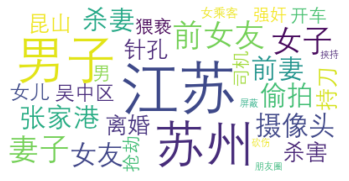

In [38]:
# Generate word clouds for the Top10 cities
for i in range(10):
    # Plot word cloud per city
    s = word_df.iloc[i, 0]
    word_cloud = WordCloud(
        collocations=False,
        background_color="white",
        max_words=30,
        font_path="viz_materials/Deng.ttf"
    ).generate(s)

    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis("off")

    # Save the plots to the repository
    plt.savefig("viz_materials/word_clouds/{}.png".format(i),
                format="png",
                dpi=50)

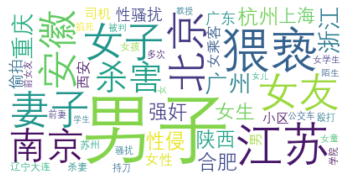

In [39]:
# Plot word cloud for all the key words in the dataframe
total_str = word_df.case.sum()

total_wc = WordCloud(
        collocations=False,
        background_color="white",
        max_words=50,
        font_path="viz_materials/Deng.ttf"
).generate(total_str)

plt.imshow(total_wc, interpolation="bilinear")
plt.axis("off")
plt.show()

<a id=4></a>
## Place Word Clouds on The Map

Interact with [WordCloudOnMap](WordCloudOnMap.html) and learn more about the data.

In [40]:
import pandas as pd
import folium
import base64

In [41]:
# Load longitude & latitude data of cities
city_lat_lng = pd.read_csv("viz_materials/city_lat_lng.csv")

# Select the subset of the data
city_lat_lng = city_lat_lng.loc[:, ["city", "lat", "lng"]]
city_lat_lng.columns = ["City", "lat", "lng"]

city_lat_lng.head()

,City,lat,lng
0,Shanghai,31.1667,121.4667
1,Guangzhou,23.1288,113.2590
2,Beijing,39.9050,116.3914
3,Shenzhen,22.5350,114.0540
4,Nanyang,32.9987,112.5292


In [42]:
# Manually preprocess the data set to match with the gb_top10 dataframe
city_lat_lng.iloc[31, 0] = "Xi'an"
city_lat_lng.drop(60, inplace=True)

# Merge the two dataframes
top10_lat_lng = (pd.merge(city_lat_lng, gb_top10, on="City", how="inner")
                   .sort_values("Count", ascending=False))
top10_lat_lng

,City,lat,lng,case,Count,City_CN,Province
2,Beijing,39.9050,116.3914,北京工业大学2001级工商管理系男学生郭某某杀害女友被判无期后减刑9次，出狱后拒戴口罩打死老...,88,北京市,Beijing
4,Nanjing,32.0500,118.7667,江苏南京大学暑期支教女学生洗澡被偷拍，做案者仅罚款500元原北大教师沈阳被指“性侵女生致其自...,48,南京市,Jiangsu
5,Hefei,31.8639,117.2808,安徽巢湖烔炀镇白庙唐村一男子唐某根将妻子勒死家中，逃亡36年安徽合肥银马公寓一男子杀妻后跳楼...,44,合肥市,Anhui
0,Shanghai,31.1667,121.4667,上海东华大学04级研究生章胜偷窥女生如厕上海财经大学副教授钱逢胜被曝性侵女学生上海海事大学解...,42,上海市,Shanghai
1,Guangzhou,23.1288,113.2590,网曝华南理工大学公共管理学院副教授王雨磊性侵女学生网曝华南理工大学公共管理学院院长王郅强性侵...,40,广州市,Guangdong
3,Chongqing,29.5500,106.5069,四川美术学院副教授王小箭餐厅强抱吻女生被处分重庆渝中区龙湖时代天街鲁某当街连捅妻子数十刀重庆...,37,重庆市,Chongqing
7,Hangzhou,30.2500,120.1675,浙大央美性搔扰惯犯崔青洲浙大学生努某某强奸被判一年半，学校不与开除，留校察看浙江杭州男子许国...,37,杭州市,Zhejiang
6,Xi'an,34.2667,108.9000,陕西西北大学新闻传播学院讲师张晓性骚扰女生陕西西安莲湖区男子李某杀害妻子潜逃15年陕西西安东...,30,西安市,Shaanxi
9,Dalian,38.9131,121.6100,辽宁大连男子酒后杀母抛尸野外辽宁大连男子趁女友不在强奸女友11岁女儿致其怀孕流产 获刑13年...,27,大连市,Liaoning
8,Suzhou,31.3040,120.6164,"江苏苏州男子王某因被妻子屏蔽朋友圈,持刀挟持妻子砍伤侄女江苏苏州高新区狮山新苑某栋3XX室一...",25,苏州市,Jiangsu


In [45]:
# Plot the crime map
M = folium.Map(location=[37, 105], zoom_start=4)

folium.Choropleth(
    geo_data="viz_materials/city_crime.geojson",
    data=merged_df,
    columns=["City", "Count"],
    key_on="feature.properties.City",
    fill_color="OrRd",
    fill_opacity=0.8,
    line_opacity=0.5,
    legend_name="Count",
    name="crime number",
    nan_fill_color="Gray",
    nan_fill_opacity=0.2,
).add_to(M)

# Add markers on the map displaying the word clouds of the top10 cities
top10_markers = folium.FeatureGroup(name="wordclouds of top10 cities")
for i in range(10):
    city, lat, lng = top10_lat_lng.iloc[i, [0, 1, 2]]

    # Load corresponding word cloud of the city
    png = "viz_materials/word_clouds/{}.png".format(i)
    encoded = base64.b64encode(open(png, "rb").read())

    html = '<img src="data:image/png;base64,{}">'.format
    iframe = folium.IFrame(html(encoded.decode()), width=320, height=220)

    # Create marker
    marker = folium.Marker(
        location=[lat, lng],
        popup=folium.Popup(iframe, max_width=600),
        icon=folium.Icon(color="red", icon="info-sign"),
    )

    top10_markers.add_children(marker)

# Add markers as a layer
M.add_children(top10_markers)

M.add_children(folium.LayerControl())

# Save the map to repository
M.save("WordCloudOnMap.html")

## Statistic Analysis

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [227]:
# Descriptive statistics
socioecon_df = pd.read_csv("socioeconomic_variables.csv", encoding="utf-8").set_index("Unnamed: 0")

socioecon_df.describe().transpose().head()

,count,mean,std,min,25%,50%,75%,max
Household Registered Population at Year-end (10 000 persons),296.0,442.297297,329.107215,20.00,231.750,375.00,577.000,3404.00
Annual Average Population (10 000 persons),292.0,440.746575,328.185395,19.00,233.500,372.00,576.000,3397.00
Number of Households at Year-end (10 000 households),296.0,144.114865,112.073766,6.00,77.750,121.50,191.250,1270.00
Birth Population (person),296.0,54656.145270,44473.964528,15.00,23863.250,43990.00,74108.750,359045.00
Natural Growth Rate(%),295.0,6.182814,5.113288,-13.22,2.765,6.29,9.645,21.89


In [228]:
socioecon_df.isnull().sum().sort_values(ascending=False).head(10)

Civil Aviation Freight Traffic (ton)                                        149
Civil Aviation Passenger Traffic                                            143
Waterway Passenger Traffic                                                  136
Waterway Freight Traffic\r\n(10 000 tons)                                   115
Total Fixed Assets                                                          104
R&D Personnel (Person)                                                      101
Unnamed: 87                                                                  94
R&D Internal Outlay (10 000 yuan)                                            89
Investment in Municipal Public Infrastructure Construction （10 000 yuan）     60
Ratio of Industrial Solid Wastes Comprehensively Utilized (%)                58
dtype: int64

In [131]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

In [230]:
socioecon_df.head()

,城 市,City,Household Registered Population at Year-end (10 000 persons),Annual Average Population (10 000 persons),Number of Households at Year-end (10 000 households),Birth Population (person),Death Population (person),Natural Growth Rate(%),Total Land Area of Administrative region （sq.km）,Total Water Resources （10 000 cu.m）,...,Revenue from Telecommunication Services (10 000 yuan),Number of Subscribers of Mobile Telephones at Year-end (10 000 households),Number of Subscribers of Internet Services (10 000 households),Annual Electricity Consumption (10 000 kwh),Electricity Consumption fbr Industrial,Household Electricity Consumption for Urban and Rural Residential,"Total Gas Supply (Coal Gas,Natural Gas) (10 000 cubic meters)",Consumption of Gas for Residential Use,Liquefied Petroleum Gas Supply (ton),Consumption of Liquefied Petroleum Gas fbr Residential Use
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1,北京市,Beijing,1376.0,1368.0,549.0,156625.0,100698,4.07,16406.0,354573.0,...,6193326.0,4009.0,635.0,11423809.0,3073165.0,2106181.0,1915978.0,141076.0,481775.0,140480.0
2,天津市,Tianjin,1082.0,1066.0,397.0,103906.0,65096,3.59,11760.0,175800.0,...,1534626.0,1680.0,491.0,8614388.0,5542514.0,816954.0,501030.0,61050.0,57326.0,38990.0
4,石家庄市,Shijiazhuang,982.0,977.0,286.0,120162.0,33091,8.87,15848.0,160795.0,...,873512.0,1376.0,374.0,4975000.0,2955000.0,303853.0,10960.0,8703.0,29211.0,18123.0
5,唐山市,Tangshan,758.0,757.0,230.0,76772.0,30699,6.08,14198.0,215500.0,...,532489.0,1002.0,220.0,7955282.0,6577123.0,236105.0,85316.0,8469.0,18327.0,16947.0
6,秦皇岛市,Qinhuangdao,300.0,299.0,115.0,28167.0,16511,3.88,7803.0,145600.0,...,233104.0,413.0,110.0,1545332.0,983172.0,102086.0,60995.0,6430.0,1182.0,989.0


In [233]:
socioecon_df.iloc[:, 2:].corr()

,Household Registered Population at Year-end (10 000 persons),Annual Average Population (10 000 persons),Number of Households at Year-end (10 000 households),Birth Population (person),Natural Growth Rate(%),Total Land Area of Administrative region （sq.km）,Total Water Resources （10 000 cu.m）,Area of Land Used for Urban Construction (sq.km),Area of Land Used for Living,Land Used for Urban Construction as Percentage to Urban Area (%),...,Revenue from Telecommunication Services (10 000 yuan),Number of Subscribers of Mobile Telephones at Year-end (10 000 households),Number of Subscribers of Internet Services (10 000 households),Annual Electricity Consumption (10 000 kwh),Electricity Consumption fbr Industrial,Household Electricity Consumption for Urban and Rural Residential,"Total Gas Supply (Coal Gas,Natural Gas) (10 000 cubic meters)",Consumption of Gas for Residential Use,Liquefied Petroleum Gas Supply (ton),Consumption of Liquefied Petroleum Gas fbr Residential Use
Household Registered Population at Year-end (10 000 persons),1.000000,0.998976,0.975939,0.910537,0.095492,-0.072199,0.305846,0.608943,0.635725,0.213757,...,0.520169,0.728293,0.782901,0.517829,0.357286,0.615291,0.418038,0.548624,0.259420,0.189385
Annual Average Population (10 000 persons),0.998976,1.000000,0.974329,0.909639,0.097990,-0.039464,0.310502,0.604589,0.631931,0.215420,...,0.517064,0.722654,0.781342,0.513326,0.353788,0.610561,0.416907,0.545601,0.256182,0.187402
Number of Households at Year-end (10 000 households),0.975939,0.974329,1.000000,0.830307,-0.023167,-0.037808,0.308898,0.670332,0.694963,0.181611,...,0.545227,0.754732,0.810981,0.548362,0.381107,0.654352,0.492429,0.630194,0.261792,0.174251
Birth Population (person),0.910537,0.909639,0.830307,1.000000,0.380533,-0.102195,0.287285,0.470254,0.502201,0.229266,...,0.462539,0.658270,0.686236,0.442665,0.298096,0.531252,0.309559,0.430404,0.295203,0.266199
Natural Growth Rate(%),0.095492,0.097990,-0.023167,0.380533,1.000000,0.001807,0.126016,-0.047792,-0.037868,0.106574,...,0.100737,0.091836,0.048388,0.034860,0.009207,0.055346,-0.048392,-0.054602,0.160160,0.234202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Household Electricity Consumption for Urban and Rural Residential,0.615291,0.610561,0.654352,0.531252,0.055346,-0.075805,0.077981,0.931059,0.921705,0.364750,...,0.885302,0.927558,0.843047,0.774572,0.532520,1.000000,0.793003,0.688484,0.606827,0.561207
"Total Gas Supply (Coal Gas,Natural Gas) (10 000 cubic meters)",0.418038,0.416907,0.492429,0.309559,-0.048392,-0.029488,-0.010168,0.786301,0.772878,0.184558,...,0.762279,0.721526,0.596043,0.592556,0.360321,0.793003,1.000000,0.661011,0.501100,0.357923
Consumption of Gas for Residential Use,0.548624,0.545601,0.630194,0.430404,-0.054602,0.029965,0.149896,0.751805,0.760554,0.177399,...,0.551136,0.686016,0.678667,0.503863,0.324776,0.688484,0.661011,1.000000,0.305307,0.241731
Liquefied Petroleum Gas Supply (ton),0.259420,0.256182,0.261792,0.295203,0.160160,-0.098258,0.005715,0.561121,0.556350,0.184811,...,0.618767,0.622498,0.451777,0.468864,0.295000,0.606827,0.501100,0.305307,1.000000,0.819614


<AxesSubplot:>

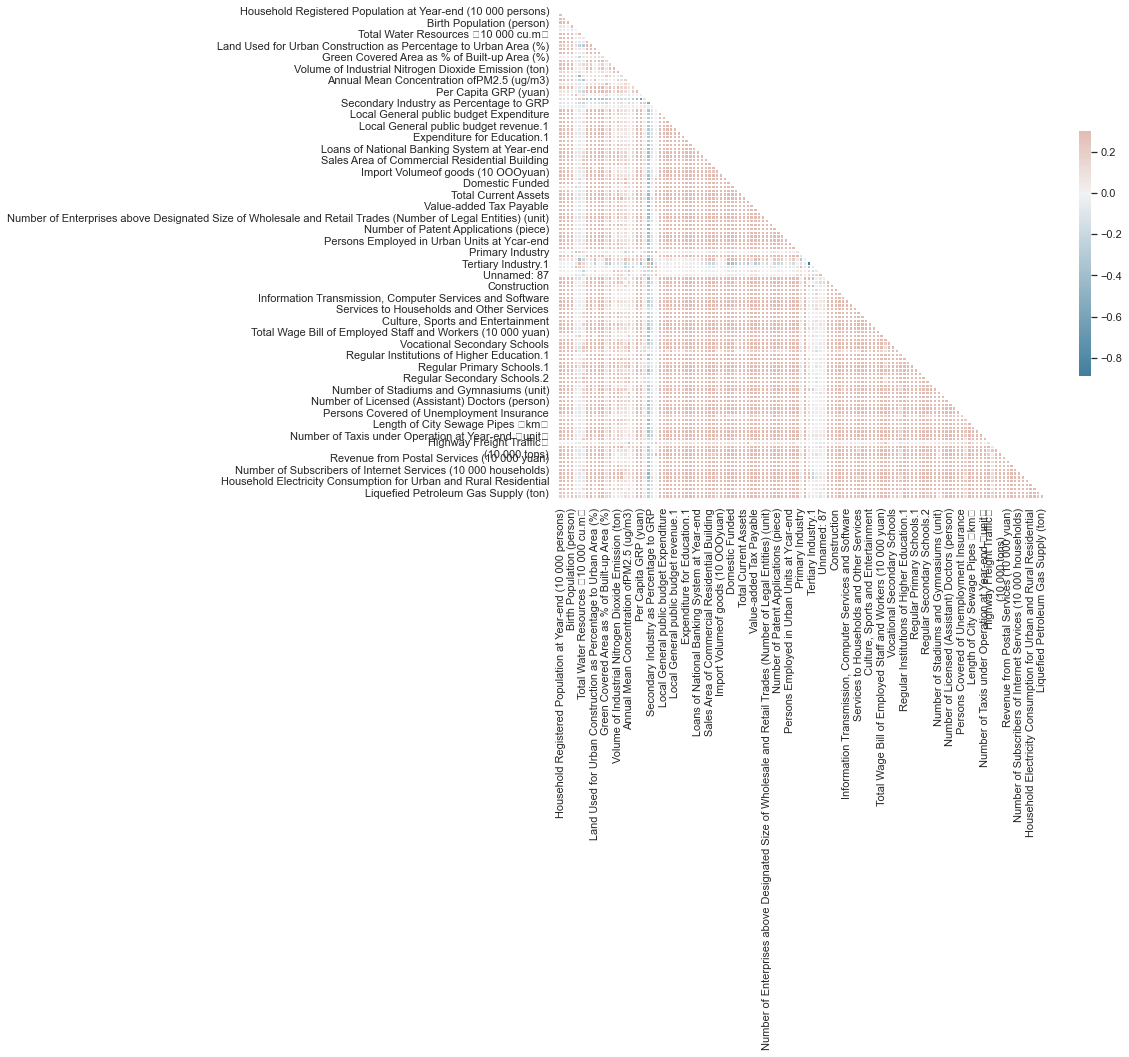

In [234]:
sns.set_theme(style="white")

corr = socioecon_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [257]:
se_small = socioecon_df.drop(["Civil Aviation Freight Traffic (ton)",
                    "Civil Aviation Passenger Traffic",
                    "Waterway Passenger Traffic",
                    "R&D Personnel (Person)",
                    "Total Fixed Assets",
                    "Waterway Freight Traffic\r\n(10 000 tons)",
                    "R&D Internal Outlay (10 000 yuan)",
                    "Unnamed: 87",
                    "Annual Mean Concentration ofPM2.5 (ug/m3)",
                    "Ratio of Industrial Solid Wastes Comprehensively Utilized (%)",
                    "Real Estate",
                    "Management of Water Conservancy, Environment"], axis=1)

In [258]:
se_small = se_small.dropna()
se_cnt = pd.merge(se_small, crime, on="City", how="inner")
se_cnt = se_cnt1.iloc[:, 2:-2].astype("float64")
se_cnt

,Household Registered Population at Year-end (10 000 persons),Annual Average Population (10 000 persons),Number of Households at Year-end (10 000 households),Birth Population (person),Death Population (person),Natural Growth Rate(%),Total Land Area of Administrative region （sq.km）,Total Water Resources （10 000 cu.m）,Area of Land Used for Urban Construction (sq.km),Area of Land Used for Living,...,Number of Subscribers of Mobile Telephones at Year-end (10 000 households),Number of Subscribers of Internet Services (10 000 households),Annual Electricity Consumption (10 000 kwh),Electricity Consumption fbr Industrial,Household Electricity Consumption for Urban and Rural Residential,"Total Gas Supply (Coal Gas,Natural Gas) (10 000 cubic meters)",Consumption of Gas for Residential Use,Liquefied Petroleum Gas Supply (ton),Consumption of Liquefied Petroleum Gas fbr Residential Use,Count
0,758.0,757.0,230.0,76772.0,30699.0,6.08,14198.0,215500.0,238.0,67.0,...,1002.0,220.0,7955282.0,6577123.0,236105.0,85316.0,8469.0,18327.0,16947.0,3.0
1,1058.0,1054.0,270.0,144759.0,43563.0,9.57,12065.0,78500.0,182.0,73.0,...,958.0,174.0,4070411.0,2923230.0,179115.0,53766.0,21023.0,358.0,353.0,6.0
2,595.0,595.0,215.0,50181.0,48267.0,0.32,13244.0,246800.0,421.0,120.0,...,894.0,181.0,3693036.0,2327906.0,362269.0,66994.0,21743.0,453503.0,25469.0,27.0
3,336.0,336.0,112.0,27787.0,17748.0,2.99,19698.0,108974.0,59.0,18.0,...,248.0,68.0,1004138.0,727560.0,65893.0,2084.0,813.0,2273.0,1600.0,1.0
4,276.0,277.0,99.0,20070.0,16308.0,1.36,10416.0,81100.0,115.0,43.0,...,242.0,67.0,1012974.0,682570.0,57083.0,17955.0,2480.0,33985.0,9232.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,254.0,254.0,82.0,35636.0,19647.0,6.29,44266.0,3449900.0,26.0,5.0,...,269.0,53.0,364449.0,177854.0,31513.0,182.0,37.0,2037.0,1977.0,1.0
80,460.0,464.0,138.0,48585.0,30980.0,3.83,9544.0,59100.0,72.0,21.0,...,502.0,123.0,1301900.0,750100.0,181500.0,27529.0,12663.0,1617.0,1589.0,10.0
81,546.0,546.0,172.0,61134.0,43433.0,3.24,13134.0,81700.0,73.0,28.0,...,524.0,89.0,1501943.0,909993.0,68383.0,6980.0,3255.0,7866.0,6830.0,4.0
82,381.0,383.0,138.0,40954.0,31897.0,2.38,27096.0,1449200.0,56.0,12.0,...,371.0,75.0,897242.0,546099.0,85431.0,8603.0,5289.0,3688.0,3576.0,7.0


In [292]:
features = [i for i in se_cnt.columns.to_list() if i != "Count"]
# Separating out the features
x = se_cnt.loc[:, features].values
# Separating out the target
y = se_cnt.loc[:, "Count"].values
# Standardizing the features
x = preprocessing.StandardScaler().fit_transform(x)

In [286]:
x

array([[ 1.0836303 ,  1.08849611,  1.05806072, ...,  0.51426829,
        -0.17411491,  0.01278514],
       [ 2.2670532 ,  2.26402103,  1.5842721 , ...,  2.67651167,
        -0.4746112 , -0.51330055],
       [ 0.44063719,  0.44730071,  0.86073146, ...,  2.80052117,
         7.10335033,  0.28296124],
       ...,
       [ 0.24734478,  0.25335888,  0.29505423, ..., -0.38376716,
        -0.34905462, -0.30795784],
       [-0.40353782, -0.39179452, -0.15222543, ..., -0.03344033,
        -0.41892348, -0.4111206 ],
       [-0.70728303, -0.70447623, -0.57319453, ..., -0.82710111,
        -0.44024535, -0.45236668]])

In [291]:
pca = PCA(n_components=2)
x_reduced = pca.fit_transform(x)
pdf = pd.DataFrame(data = x_reduced,
                   columns = ['principal component 1',
                              'principal component 2'])
df = pd.concat([pdf, se_cnt.Count], axis = 1)
df

,principal component 1,principal component 2,Count
0,8.355390,5.604858,3.0
1,5.021899,8.835672,6.0
2,15.977017,-2.263877,27.0
3,-6.131119,-0.164978,1.0
4,-6.182189,-1.445261,6.0
...,...,...,...
79,-7.599127,-0.332484,1.0
80,-2.346643,1.113503,10.0
81,-2.690840,3.507712,4.0
82,-5.099218,0.312429,7.0


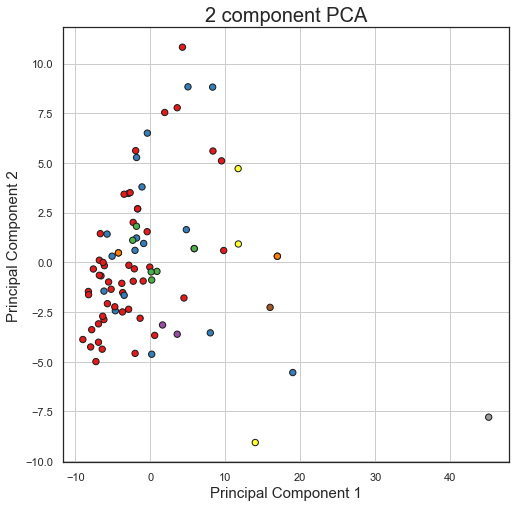

In [293]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

ax.scatter(x_reduced[:, 0], x_reduced[:, 1], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.grid()

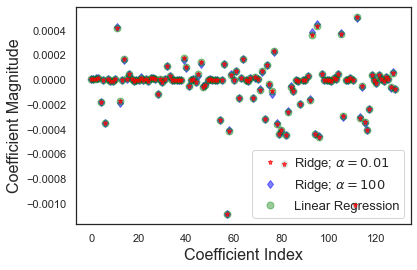

In [299]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# X_train,X_test,y_train,y_test=train_test_split(newX,newY,test_size=0.3,random_state=3)

X = se_cnt.iloc[:, :-1]
Y = se_cnt.Count

lr = LinearRegression()
lr.fit(X, Y)

rr = Ridge(alpha=0.01) 
# higher the alpha value, more restriction on the coefficients; low alpha > more generalization,
# in this case linear and ridge regression resembles
rr.fit(X, y)
rr100 = Ridge(alpha=100) #  comparison with alpha value
rr100.fit(X, y)
train_score=lr.score(X, Y)
#test_score=lr.score(X_test, y_test)

Ridge_train_score = rr.score(X, Y)
#Ridge_test_score = rr.score(X_test, y_test)

Ridge_train_score100 = rr100.score(X,Y)
#Ridge_test_score100 = rr100.score(X_test, y_test)

plt.plot(rr.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 0.01$',zorder=7) 
plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Ridge; $\alpha = 100$') 
plt.plot(lr.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()

training score: 0.9284188092503025
number of features used:  99
training score for alpha=0.01: 0.9306610745088248
number of features used: for alpha =0.01: 96
training score for alpha=0.0001: 0.9306610971564705
number of features used: for alpha =0.0001: 121
LR training score: 0.9306610988370682


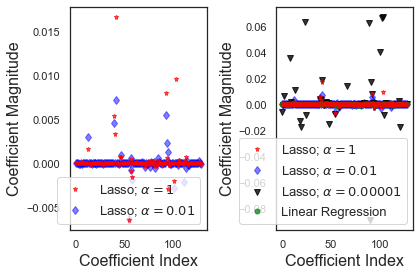

In [306]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

X = se_cnt.iloc[:, :-1]
Y = se_cnt.Count

# X_train,X_test,y_train,y_test=train_test_split(X,Y, test_size=0.3, random_state=31)
lasso = Lasso()
lasso.fit(X, Y)
train_score=lasso.score(X, Y)
# test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print("training score:", train_score)
# print "test score: ", test_score
print("number of features used: ", coeff_used)

lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X, Y)
train_score001=lasso001.score(X, Y)
# test_score001=lasso001.score(X_test,y_test)
coeff_used001 = np.sum(lasso001.coef_!=0)
print("training score for alpha=0.01:", train_score001)
# print "test score for alpha =0.01: ", test_score001
print("number of features used: for alpha =0.01:", coeff_used001)

lasso00001 = Lasso(alpha=0.0001, max_iter=10e5)
lasso00001.fit(X, Y)
train_score00001=lasso00001.score(X, Y)
# test_score00001=lasso00001.score(X_test,y_test)
coeff_used00001 = np.sum(lasso00001.coef_!=0)
print("training score for alpha=0.0001:", train_score00001)
# print "test score for alpha =0.0001: ", test_score00001
print("number of features used: for alpha =0.0001:", coeff_used00001)


lr = LinearRegression()
lr.fit(X, Y)
lr_train_score=lr.score(X, Y)
# lr_test_score=lr.score(X_test,y_test)
print("LR training score:", lr_train_score)
# print("LR test score: ", lr_test_score)
plt.subplot(1,2,1)
plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
plt.plot(lasso001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency

plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.subplot(1,2,2)
plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
plt.plot(lasso001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency
plt.plot(lasso00001.coef_,alpha=0.8,linestyle='none',marker='v',markersize=6,color='black',label=r'Lasso; $\alpha = 0.00001$') # alpha here is for transparency
plt.plot(lr.coef_,alpha=0.7,linestyle='none',marker='o',markersize=5,color='green',label='Linear Regression',zorder=2)
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.tight_layout()
plt.show()


In [308]:
lr.coef_

array([ 7.68520282e-06,  6.70733471e-06,  9.90280063e-06,  1.27561537e-05,
       -1.79353146e-04,  1.65236851e-06, -3.48045184e-04,  6.21059454e-06,
       -1.32487428e-05, -1.06627726e-05,  8.98799561e-06,  4.18574436e-04,
       -1.74848538e-04, -9.99049350e-08,  1.64653436e-04,  9.95551880e-06,
        4.79649335e-05,  7.06127474e-06, -9.14949133e-06, -3.48460284e-06,
       -6.52601526e-07,  1.75631353e-05,  2.45200010e-08,  1.96409760e-06,
       -1.30032003e-05,  1.10488597e-05,  1.12954386e-05,  3.50927544e-06,
       -1.17236380e-04,  2.52288012e-06, -2.11197942e-05,  4.47733677e-06,
        1.12961167e-04,  2.85752639e-05, -1.81089699e-07, -1.60988478e-07,
        5.13547961e-07, -3.18663068e-06,  5.40767779e-07,  1.72695332e-04,
        1.01014166e-04, -5.28111043e-05, -8.16511349e-07,  6.15853219e-06,
       -1.43999808e-05,  4.67629892e-05,  1.43857839e-04, -5.50861175e-05,
       -4.20884849e-05,  9.13429579e-07,  2.01990202e-06, -7.17018948e-07,
       -1.19990529e-06, -